# Hybrid Ensemble Learning: Classification and Clustering

## Project Overview

This project implements a **hybrid (ensemble) classifier** based on the aggregation of both supervised and unsupervised learning methods.

### Ensemble Classification Methods:
- **MLP Neural Network** - Multi-layer Perceptron
- **RBF Neural Network** - Radial Basis Function Network
- **k-NN Algorithm** - k-Nearest Neighbors
- **GP Algorithm** - Gaussian Process Classifier
- **Naïve Bayes Algorithm** - Gaussian Naive Bayes

### Ensemble Clustering Methods:
- **k-Means Algorithm**
- **k-Medoids Algorithm**
- **DIANA Algorithm** - Divisive Analysis

### Datasets:
- **RCV1 (Reuters)** - Text classification dataset
- **Forest Covtype** - Forest cover type prediction dataset

### Evaluation Metrics:
- **Classification**: Accuracy, Precision, Sensitivity (Recall)
- **Clustering**: Rand Index, F-measure

---
## Part 1: Installing and Importing Required Libraries

First, we need to install all necessary libraries for machine learning, clustering, and visualization.

In [1]:
# Install required packages
!pip install scikit-learn numpy pandas matplotlib seaborn scikit-learn-extra

### Import Core Libraries

We import NumPy for numerical operations, Pandas for data manipulation, and Matplotlib/Seaborn for visualization.

In [2]:
# Core libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Core libraries imported successfully")

✓ Core libraries imported successfully


### Import Machine Learning Libraries

We import all the classifiers, clustering algorithms, and evaluation metrics from scikit-learn.

In [3]:
# Data preprocessing and model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD, PCA

# Classification metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score,
    confusion_matrix, 
    classification_report,
    f1_score
)

# Clustering metrics
from sklearn.metrics import (
    adjusted_rand_score,
    silhouette_score,
    normalized_mutual_info_score
)
from sklearn.metrics.cluster import contingency_matrix

# Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF as RBF_Kernel, ConstantKernel
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

# Clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids

# Ensemble methods
from sklearn.ensemble import VotingClassifier

print("✓ Machine learning libraries imported successfully")

✓ Machine learning libraries imported successfully


---
## Part 2: Loading and Preparing Datasets

We use two real-world datasets from scikit-learn:

1. **Forest Covtype**: Contains cartographic variables to predict forest cover type. It has 54 features and 7 classes.

2. **RCV1 (Reuters)**: A text classification dataset with news articles. It's a multi-label, sparse dataset.

### 2.1 Load Forest Covtype Dataset

The Forest Covertype dataset contains 581,012 samples with 54 features. Due to computational constraints, we sample a subset for training.

In [4]:
from sklearn.datasets import fetch_openml

print("Loading Forest Covtype dataset from OpenML...")

covtype = fetch_openml(data_id=150, as_frame=False, parser='auto')

covtype.target = covtype.target.astype(int)


print(f"\nDataset Description:")
print(f"- Total samples: {covtype.data.shape[0]:,}")  # Matches 581,012
print(f"- Number of features: {covtype.data.shape[1]}")  # Matches 54
print(f"- Number of classes: {len(np.unique(covtype.target))}")
print(f"- Class labels: {np.unique(covtype.target)}")

Loading Forest Covtype dataset from OpenML...

Dataset Description:
- Total samples: 581,012
- Number of features: 54
- Number of classes: 7
- Class labels: [1 2 3 4 5 6 7]


In [5]:
# Sample a subset for faster computation
# Using stratified sampling to maintain class distribution
COVTYPE_SAMPLE_SIZE = 20000

indices = np.random.choice(len(covtype.data), COVTYPE_SAMPLE_SIZE, replace=False)
X_covtype = covtype.data[indices]
y_covtype = covtype.target[indices]

print(f"Sampled dataset:")
print(f"- Shape: {X_covtype.shape}")
print(f"\nClass distribution:")
for cls, count in sorted(Counter(y_covtype).items()):
    print(f"  Class {cls}: {count} samples ({100*count/len(y_covtype):.1f}%)")

Sampled dataset:
- Shape: (20000, 54)

Class distribution:
  Class 1: 7365 samples (36.8%)
  Class 2: 9725 samples (48.6%)
  Class 3: 1207 samples (6.0%)
  Class 4: 85 samples (0.4%)
  Class 5: 317 samples (1.6%)
  Class 6: 627 samples (3.1%)
  Class 7: 674 samples (3.4%)


### 2.2 Load RCV1 (Reuters) Dataset

RCV1 is a sparse text classification dataset. We'll reduce its dimensionality using TruncatedSVD for efficiency.

In [6]:

from sklearn.datasets import fetch_openml

print("Loading RCV1 (Reuters) dataset...")
print("(This may take a few minutes on first run)")

rcv1 = fetch_openml(data_id=41671, as_frame=False, parser='auto')

print(f"\nDataset Description:")
print(f"- Total samples: {rcv1.data.shape[0]:,}")
print(f"- Number of features: {rcv1.data.shape[1]:,}")

# Logic to calculate target categories to match your original print statement
if hasattr(rcv1.target, 'shape') and len(rcv1.target.shape) > 1:
    n_categories = rcv1.target.shape[1]
else:
    # Fallback if the target was flattened
    n_categories = len(np.unique(rcv1.target))

print(f"- Number of target categories: {n_categories}")

Loading RCV1 (Reuters) dataset...
(This may take a few minutes on first run)

Dataset Description:
- Total samples: 20,000
- Number of features: 20
- Number of target categories: 5


In [ ]:
# Sample and preprocess RCV1 data
RCV1_SAMPLE_SIZE = 10000
N_COMPONENTS = 19  # Reduced dimensions after SVD

# Random sampling
indices_rcv1 = np.random.choice(rcv1.data.shape[0], RCV1_SAMPLE_SIZE, replace=False)
X_rcv1_sparse = rcv1.data[indices_rcv1]

# Convert to dense array for processing
X_rcv1 = X_rcv1_sparse

# For multi-label dataset, use the most frequent label for each sample
y_rcv1 = rcv1.target[indices_rcv1].astype(int)

print(f"Original sampled shape: {X_rcv1.shape}")

# Apply dimensionality reduction using TruncatedSVD
print(f"\nApplying TruncatedSVD for dimensionality reduction...")
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)
X_rcv1_reduced = svd.fit_transform(X_rcv1)

print(f"Reduced shape: {X_rcv1_reduced.shape}")
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")
print(f"Number of unique classes: {len(np.unique(y_rcv1))}")

(20000,)
Original sampled shape: (10000, 20)

Applying TruncatedSVD for dimensionality reduction...
Reduced shape: (10000, 19)
Explained variance ratio: 1.0000
Number of unique classes: 5


### 2.3 Data Preparation Function

This function handles:
- Train/test splitting with stratification
- Feature standardization (zero mean, unit variance)

In [8]:
def prepare_data(X, y, test_size=0.2, random_state=42):
    """
    Prepare data for machine learning:
    - Split into train/test sets with stratification
    - Standardize features
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix
    y : array-like, shape (n_samples,)
        Target labels
    test_size : float
        Proportion of data for testing
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X_train_scaled, X_test_scaled, y_train, y_test, scaler
    """
    # Split data with stratification to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=y
    )
    
    # Standardize features (important for neural networks and distance-based methods)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

print("✓ Data preparation function defined")

✓ Data preparation function defined


In [9]:
# Prepare Forest Covtype data
print("Preparing Forest Covtype data...")
X_train_cov, X_test_cov, y_train_cov, y_test_cov, scaler_cov = prepare_data(
    X_covtype, y_covtype
)
print(f"Training set size: {X_train_cov.shape[0]}")
print(f"Test set size: {X_test_cov.shape[0]}")

# Prepare RCV1 data
print("\nPreparing RCV1 data...")
X_train_rcv, X_test_rcv, y_train_rcv, y_test_rcv, scaler_rcv = prepare_data(
    X_rcv1_reduced, y_rcv1
)
print(f"Training set size: {X_train_rcv.shape[0]}")
print(f"Test set size: {X_test_rcv.shape[0]}")

Preparing Forest Covtype data...
Training set size: 16000
Test set size: 4000

Preparing RCV1 data...
Training set size: 8000
Test set size: 2000


---
## Part 3: Implementing Base Classifiers

We implement five base classifiers with hyperparameter optimization:

1. **MLP (Multi-Layer Perceptron)**: Deep neural network with backpropagation
2. **RBF Network**: Uses radial basis function kernels
3. **k-NN**: Instance-based learning using neighbor distances
4. **Gaussian Process**: Probabilistic classifier using GP priors
5. **Naive Bayes**: Probabilistic classifier assuming feature independence

### 3.1 Classifier Manager Class

This class manages multiple classifiers, handles hyperparameter optimization, training, and evaluation.

In [10]:
class ClassifierManager:
    """
    A manager class for handling multiple classifiers with:
    - Hyperparameter optimization using GridSearchCV
    - Training and evaluation
    - Results storage and comparison
    """
    
    def __init__(self):
        self.classifiers = {}      # Stores classifier definitions
        self.best_params = {}      # Stores optimal parameters
        self.results = {}          # Stores evaluation results
        self.cv_scores = {}        # Stores cross-validation scores
    
    def add_classifier(self, name, classifier, param_grid=None):
        """
        Add a classifier to the manager.
        
        Parameters:
        -----------
        name : str
            Identifier for the classifier
        classifier : estimator
            Scikit-learn compatible classifier
        param_grid : dict or None
            Hyperparameter search space for GridSearchCV
        """
        self.classifiers[name] = {
            'model': classifier,
            'param_grid': param_grid
        }
    
    def optimize_and_train(self, X_train, y_train, cv=3, verbose=True):
        """
        Optimize hyperparameters and train all classifiers.
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        y_train : array-like
            Training labels
        cv : int
            Number of cross-validation folds
        verbose : bool
            Print progress information
        """
        for name, clf_info in self.classifiers.items():
            if verbose:
                print(f"\n{'='*50}")
                print(f"Training: {name}")
                print(f"{'='*50}")
            
            if clf_info['param_grid'] is not None:
                # Perform grid search for hyperparameter optimization
                grid_search = GridSearchCV(
                    clf_info['model'],
                    clf_info['param_grid'],
                    cv=cv,
                    scoring='accuracy',
                    n_jobs=-1,
                    return_train_score=True
                )
                grid_search.fit(X_train, y_train)
                
                # Store results
                self.best_params[name] = grid_search.best_params_
                self.classifiers[name]['trained_model'] = grid_search.best_estimator_
                self.cv_scores[name] = grid_search.best_score_
                
                if verbose:
                    print(f"Best parameters: {grid_search.best_params_}")
                    print(f"Best CV score: {grid_search.best_score_:.4f}")
            else:
                # Train with default parameters
                clf_info['model'].fit(X_train, y_train)
                self.classifiers[name]['trained_model'] = clf_info['model']
                self.best_params[name] = "Default parameters"
                
                if verbose:
                    print("Using default parameters")
    
    def evaluate(self, X_test, y_test):
        """
        Evaluate all trained classifiers on test data.
        
        Returns:
        --------
        dict : Evaluation results for each classifier
        """
        for name, clf_info in self.classifiers.items():
            if 'trained_model' in clf_info:
                y_pred = clf_info['trained_model'].predict(X_test)
                
                self.results[name] = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
                    'sensitivity': recall_score(y_test, y_pred, average='weighted', zero_division=0),
                    'f1': f1_score(y_test, y_pred, average='weighted', zero_division=0),
                    'predictions': y_pred
                }
        return self.results
    
    def get_trained_classifiers(self):
        """Return dictionary of trained classifier objects."""
        return {
            name: info['trained_model'] 
            for name, info in self.classifiers.items() 
            if 'trained_model' in info
        }
    
    def get_results_dataframe(self):
        """Return results as a pandas DataFrame."""
        return pd.DataFrame({
            'Classifier': list(self.results.keys()),
            'Accuracy': [self.results[k]['accuracy'] for k in self.results],
            'Precision': [self.results[k]['precision'] for k in self.results],
            'Sensitivity': [self.results[k]['sensitivity'] for k in self.results],
            'F1-Score': [self.results[k]['f1'] for k in self.results]
        })

print("✓ ClassifierManager class defined")

✓ ClassifierManager class defined


### 3.2 Define Base Classifiers with Parameter Grids

Each classifier is defined with a search space for hyperparameter optimization.

In [11]:
# ============================================================
# 1. MLP Neural Network
# ============================================================
# Multi-layer Perceptron with backpropagation
# Key parameters:
#   - hidden_layer_sizes: architecture of hidden layers
#   - activation: activation function (relu, tanh)
#   - alpha: L2 regularization term
#   - learning_rate: learning rate schedule

mlp_classifier = MLPClassifier(
    max_iter=500,           # Maximum iterations
    random_state=42,
    early_stopping=True,    # Stop when validation score stops improving
    validation_fraction=0.1
)

mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (128, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

print("MLP Classifier defined")
print(f"  Parameter combinations: {np.prod([len(v) for v in mlp_param_grid.values()])}")

MLP Classifier defined
  Parameter combinations: 48


In [12]:
# ============================================================
# 2. RBF Neural Network
# ============================================================
# Approximation of RBF network using:
#   - RBFSampler: approximates RBF kernel feature map
#   - SGDClassifier: linear classifier with SGD optimization
#
# This combination approximates an RBF network by:
#   1. Transforming input features to RBF kernel space
#   2. Training a linear classifier in that space

rbf_classifier = Pipeline([
    ('rbf_feature', RBFSampler(random_state=42)),
    ('sgd', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])

rbf_param_grid = {
    'rbf_feature__gamma': [0.01, 0.1, 1.0],      # RBF kernel width
    'rbf_feature__n_components': [50, 100, 200],  # Number of RBF centers
    'sgd__alpha': [0.0001, 0.001, 0.01]           # Regularization
}

print("RBF Classifier defined")
print(f"  Parameter combinations: {np.prod([len(v) for v in rbf_param_grid.values()])}")

RBF Classifier defined
  Parameter combinations: 27


In [13]:
# ============================================================
# 3. k-Nearest Neighbors (k-NN)
# ============================================================
# Instance-based learning algorithm that classifies based on
# the k closest training examples in feature space.
#
# Key parameters:
#   - n_neighbors: number of neighbors to consider
#   - weights: how to weight neighbor contributions
#   - metric: distance measure

knn_classifier = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print("k-NN Classifier defined")
print(f"  Parameter combinations: {np.prod([len(v) for v in knn_param_grid.values()])}")

k-NN Classifier defined
  Parameter combinations: 30


In [14]:
# ============================================================
# 4. Gaussian Process Classifier
# ============================================================
# A probabilistic classifier that uses Gaussian process priors.
# Note: GP classifiers are computationally expensive O(n³),
# so we'll use a smaller subset for training.
#
# Key parameter:
#   - kernel: defines similarity between points

gp_classifier = GaussianProcessClassifier(
    random_state=42,
    max_iter_predict=100,
    n_restarts_optimizer=0  # Reduce for speed
)

# Define different RBF kernel configurations
gp_param_grid = {
    'kernel': [
        1.0 * RBF_Kernel(length_scale=0.5),
        1.0 * RBF_Kernel(length_scale=1.0),
        1.0 * RBF_Kernel(length_scale=2.0)
    ]
}

print("Gaussian Process Classifier defined")
print("  Note: Will use smaller subset due to O(n³) complexity")

Gaussian Process Classifier defined
  Note: Will use smaller subset due to O(n³) complexity


In [15]:
# ============================================================
# 5. Gaussian Naive Bayes
# ============================================================
# Probabilistic classifier based on Bayes' theorem with
# the "naive" assumption of feature independence.
#
# Key parameter:
#   - var_smoothing: portion of largest variance added
#     to variances for calculation stability

nb_classifier = GaussianNB()

nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

print("Naive Bayes Classifier defined")
print(f"  Parameter combinations: {len(nb_param_grid['var_smoothing'])}")

Naive Bayes Classifier defined
  Parameter combinations: 5


### 3.3 Train and Evaluate on Forest Covtype Dataset

In [16]:
# Initialize classifier manager for Forest Covtype
clf_manager_cov = ClassifierManager()

# Add classifiers (except GP which needs special handling)
clf_manager_cov.add_classifier('MLP', mlp_classifier, mlp_param_grid)
clf_manager_cov.add_classifier('RBF', rbf_classifier, rbf_param_grid)
clf_manager_cov.add_classifier('KNN', knn_classifier, knn_param_grid)
clf_manager_cov.add_classifier('Naive Bayes', nb_classifier, nb_param_grid)

print("Classifiers added to manager:")
for name in clf_manager_cov.classifiers:
    print(f"  - {name}")

Classifiers added to manager:
  - MLP
  - RBF
  - KNN
  - Naive Bayes


In [17]:
# Train classifiers on Forest Covtype (this may take several minutes)
print("\n" + "="*60)
print("TRAINING CLASSIFIERS ON FOREST COVTYPE")
print("="*60)

clf_manager_cov.optimize_and_train(X_train_cov, y_train_cov, cv=3)


TRAINING CLASSIFIERS ON FOREST COVTYPE

Training: MLP
Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant'}
Best CV score: 0.7862

Training: RBF
Best parameters: {'rbf_feature__gamma': 0.01, 'rbf_feature__n_components': 200, 'sgd__alpha': 0.0001}
Best CV score: 0.7196

Training: KNN
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV score: 0.7832

Training: Naive Bayes
Best parameters: {'var_smoothing': 1e-05}
Best CV score: 0.1761


In [18]:
# Train Gaussian Process separately with smaller sample
# (GP is O(n³) complexity, so we use a subset)
print("\n" + "="*50)
print("Training: Gaussian Process (with reduced sample)")
print("="*50)

GP_SAMPLE_SIZE = 2000
gp_indices = np.random.choice(len(X_train_cov), GP_SAMPLE_SIZE, replace=False)
X_train_gp = X_train_cov[gp_indices]
y_train_gp = y_train_cov[gp_indices]

print(f"Using {GP_SAMPLE_SIZE} samples for GP training")

# Train GP with best kernel from grid search on small subset
best_gp_score = 0
best_gp_kernel = None
best_gp_model = None

for kernel in gp_param_grid['kernel']:
    gp = GaussianProcessClassifier(kernel=kernel, random_state=42, max_iter_predict=100)
    gp.fit(X_train_gp, y_train_gp)
    score = gp.score(X_train_gp, y_train_gp)
    if score > best_gp_score:
        best_gp_score = score
        best_gp_kernel = kernel
        best_gp_model = gp

# Add GP to manager
clf_manager_cov.classifiers['GP'] = {'trained_model': best_gp_model}
clf_manager_cov.best_params['GP'] = {'kernel': str(best_gp_kernel), 'sample_size': GP_SAMPLE_SIZE}

print(f"Best kernel: {best_gp_kernel}")
print(f"Training accuracy: {best_gp_score:.4f}")


Training: Gaussian Process (with reduced sample)
Using 2000 samples for GP training


Exception ignored in: <function ResourceTracker.__del__ at 0x7fca9541df80>
Traceback (most recent call last):
  File "/home/hasan/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/hasan/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/hasan/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f6710611f80>
Traceback (most recent call last):
  File "/home/hasan/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/hasan/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/hasan/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ 

Best kernel: 1**2 * RBF(length_scale=1)
Training accuracy: 0.7820


In [19]:
# Evaluate all classifiers
print("\n" + "="*60)
print("EVALUATION RESULTS - FOREST COVTYPE")
print("="*60)

results_cov = clf_manager_cov.evaluate(X_test_cov, y_test_cov)
results_df_cov = clf_manager_cov.get_results_dataframe()

# Sort by accuracy
results_df_cov = results_df_cov.sort_values('Accuracy', ascending=False)

print("\nBase Classifier Results:")
print(results_df_cov.to_string(index=False))


EVALUATION RESULTS - FOREST COVTYPE

Base Classifier Results:
 Classifier  Accuracy  Precision  Sensitivity  F1-Score
        MLP   0.81325   0.812279      0.81325  0.810162
        KNN   0.80450   0.803193      0.80450  0.802739
         GP   0.72675   0.707759      0.72675  0.711136
        RBF   0.72650   0.713997      0.72650  0.711591
Naive Bayes   0.17400   0.724390      0.17400  0.204165


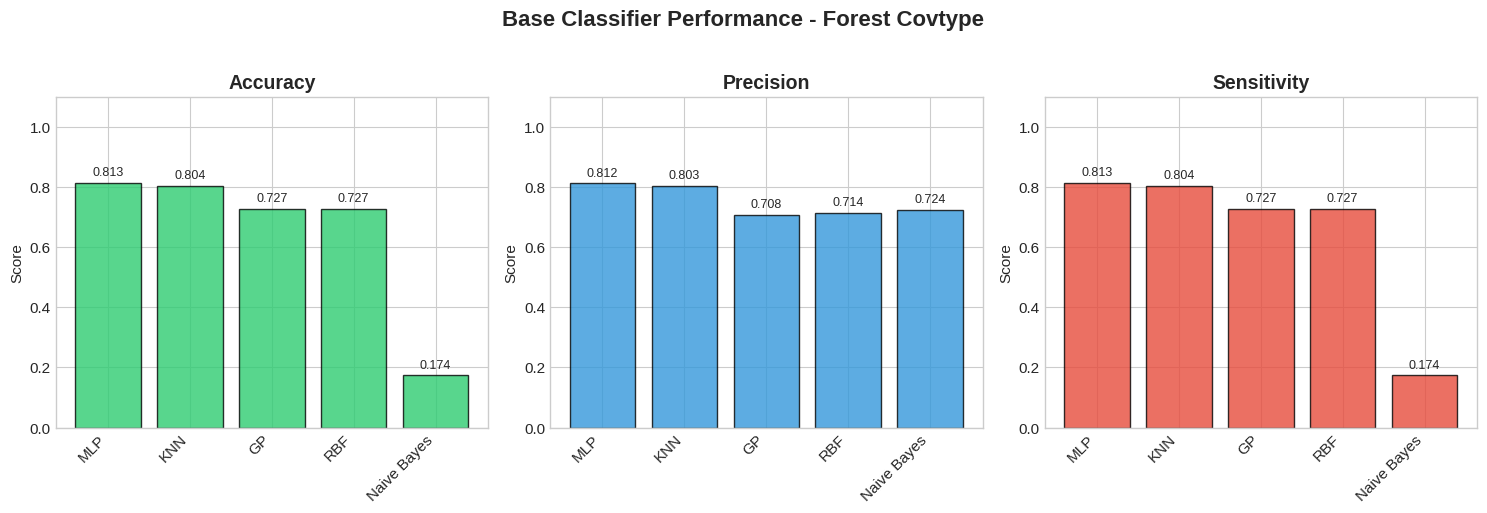

In [20]:
# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Accuracy', 'Precision', 'Sensitivity']
colors = ['#2ecc71', '#3498db', '#e74c3c']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx]
    bars = ax.bar(results_df_cov['Classifier'], results_df_cov[metric], 
                  color=color, alpha=0.8, edgecolor='black')
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Score')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)

plt.suptitle('Base Classifier Performance - Forest Covtype', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.4 Display Optimal Parameters

Summary of the best hyperparameters found for each classifier.

In [21]:
print("\n" + "="*60)
print("OPTIMAL PARAMETERS - FOREST COVTYPE")
print("="*60)

for name, params in clf_manager_cov.best_params.items():
    print(f"\n{name}:")
    if isinstance(params, dict):
        for param_name, value in params.items():
            print(f"  {param_name}: {value}")
    else:
        print(f"  {params}")


OPTIMAL PARAMETERS - FOREST COVTYPE

MLP:
  activation: tanh
  alpha: 0.0001
  hidden_layer_sizes: (128, 64)
  learning_rate: constant

RBF:
  rbf_feature__gamma: 0.01
  rbf_feature__n_components: 200
  sgd__alpha: 0.0001

KNN:
  metric: manhattan
  n_neighbors: 3
  weights: distance

Naive Bayes:
  var_smoothing: 1e-05

GP:
  kernel: 1**2 * RBF(length_scale=1)
  sample_size: 2000


---
## Part 4: Implementing Ensemble Classifier

We combine the base classifiers using multiple ensemble strategies:

1. **Hard Voting**: Each classifier votes for a class, majority wins
2. **Soft Voting**: Average predicted probabilities across classifiers
3. **Weighted Voting**: Like hard voting but with optimized weights

### 4.1 Custom Ensemble Classifier Class

In [22]:
class CustomEnsembleClassifier:
    """
    Custom ensemble classifier with multiple voting strategies:
    - Hard Voting: Majority vote
    - Soft Voting: Average probabilities
    - Weighted Voting: Weighted majority vote
    
    Parameters:
    -----------
    classifiers : dict
        Dictionary of trained classifier objects {name: classifier}
    voting : str
        Voting strategy: 'hard', 'soft', or 'weighted'
    weights : dict or None
        Weights for each classifier (used in weighted voting)
    """
    
    def __init__(self, classifiers, voting='hard', weights=None):
        self.classifiers = classifiers
        self.voting = voting
        self.weights = weights if weights else {name: 1.0 for name in classifiers}
        self.classes_ = None
    
    def predict(self, X):
        """Make predictions using the ensemble."""
        if self.voting == 'hard':
            return self._hard_voting(X)
        elif self.voting == 'weighted':
            return self._weighted_voting(X)
        elif self.voting == 'soft':
            return self._soft_voting(X)
    
    def _hard_voting(self, X):
        """
        Hard voting: Each classifier votes, class with most votes wins.
        """
        predictions = np.array([clf.predict(X) for clf in self.classifiers.values()])
        # Transpose to get predictions per sample
        predictions = predictions.T
        
        final_pred = []
        for row in predictions:
            counter = Counter(row)
            final_pred.append(counter.most_common(1)[0][0])
        
        return np.array(final_pred)
    
    def _weighted_voting(self, X):
        """
        Weighted voting: Each classifier's vote is weighted.
        """
        predictions = {name: clf.predict(X) for name, clf in self.classifiers.items()}
        n_samples = len(list(predictions.values())[0])
        
        final_pred = []
        for i in range(n_samples):
            weighted_votes = {}
            for name, preds in predictions.items():
                pred = preds[i]
                if pred not in weighted_votes:
                    weighted_votes[pred] = 0
                weighted_votes[pred] += self.weights[name]
            
            final_pred.append(max(weighted_votes, key=weighted_votes.get))
        
        return np.array(final_pred)
    
    def _soft_voting(self, X):
        """
        Soft voting: Average predicted probabilities.
        Falls back to hard voting if classifiers don't support predict_proba.
        """
        probas = []
        for name, clf in self.classifiers.items():
            if hasattr(clf, 'predict_proba'):
                try:
                    proba = clf.predict_proba(X)
                    probas.append(proba * self.weights[name])
                except:
                    pass
        
        if not probas:
            return self._hard_voting(X)
        
        # Average probabilities
        avg_proba = np.mean(probas, axis=0)
        
        # Get the classes from the first classifier that has them
        for clf in self.classifiers.values():
            if hasattr(clf, 'classes_'):
                return clf.classes_[np.argmax(avg_proba, axis=1)]
        
        return np.argmax(avg_proba, axis=1)

print("✓ CustomEnsembleClassifier class defined")

✓ CustomEnsembleClassifier class defined


### 4.2 Weight Optimization Function

Optimize ensemble weights using random search with validation data.

In [23]:
def optimize_ensemble_weights(classifiers, X_val, y_val, n_iterations=100, verbose=True):
    """
    Optimize ensemble weights using random search.
    
    Parameters:
    -----------
    classifiers : dict
        Dictionary of trained classifiers
    X_val : array-like
        Validation features
    y_val : array-like
        Validation labels
    n_iterations : int
        Number of random weight combinations to try
    verbose : bool
        Print progress
        
    Returns:
    --------
    best_weights : dict
        Optimal weights for each classifier
    best_accuracy : float
        Best validation accuracy achieved
    """
    best_weights = None
    best_accuracy = 0
    clf_names = list(classifiers.keys())
    
    if verbose:
        print(f"Optimizing weights with {n_iterations} iterations...")
    
    for i in range(n_iterations):
        # Generate random weights using Dirichlet distribution
        # This ensures weights sum to 1 and are all positive
        random_weights = np.random.dirichlet(np.ones(len(clf_names)))
        weights = {name: w for name, w in zip(clf_names, random_weights)}
        
        # Create ensemble with these weights
        ensemble = CustomEnsembleClassifier(classifiers, voting='weighted', weights=weights)
        
        # Evaluate
        y_pred = ensemble.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights = weights.copy()
    
    if verbose:
        print(f"Best validation accuracy: {best_accuracy:.4f}")
    
    return best_weights, best_accuracy

print("✓ Weight optimization function defined")

✓ Weight optimization function defined


### 4.3 Build and Evaluate Ensemble Classifiers

In [24]:
# Get trained classifiers
trained_classifiers_cov = clf_manager_cov.get_trained_classifiers()

print("Trained classifiers available for ensemble:")
for name in trained_classifiers_cov:
    print(f"  - {name}")

Trained classifiers available for ensemble:
  - MLP
  - RBF
  - KNN
  - Naive Bayes
  - GP


In [25]:
# Split test set into validation and final test
# Validation set is used for weight optimization
val_size = int(len(X_test_cov) * 0.3)
X_val_cov = X_test_cov[:val_size]
y_val_cov = y_test_cov[:val_size]
X_final_test_cov = X_test_cov[val_size:]
y_final_test_cov = y_test_cov[val_size:]

print(f"Validation set size: {len(X_val_cov)}")
print(f"Final test set size: {len(X_final_test_cov)}")

Validation set size: 1200
Final test set size: 2800


In [26]:
# Optimize ensemble weights
print("\n" + "="*60)
print("OPTIMIZING ENSEMBLE WEIGHTS")
print("="*60)

best_weights_cov, val_accuracy = optimize_ensemble_weights(
    trained_classifiers_cov, 
    X_val_cov, 
    y_val_cov, 
    n_iterations=100
)

print("\nOptimal weights found:")
for name, weight in sorted(best_weights_cov.items(), key=lambda x: -x[1]):
    print(f"  {name}: {weight:.4f}")


OPTIMIZING ENSEMBLE WEIGHTS
Optimizing weights with 100 iterations...
Best validation accuracy: 0.8208

Optimal weights found:
  MLP: 0.4430
  Naive Bayes: 0.2927
  GP: 0.1191
  RBF: 0.0746
  KNN: 0.0706


In [27]:
# Evaluate different ensemble strategies
print("\n" + "="*60)
print("ENSEMBLE CLASSIFIER EVALUATION")
print("="*60)

ensemble_results_cov = {}

# 1. Hard Voting
print("\n1. Evaluating Hard Voting...")
ensemble_hard = CustomEnsembleClassifier(trained_classifiers_cov, voting='hard')
y_pred_hard = ensemble_hard.predict(X_final_test_cov)
ensemble_results_cov['Hard Voting'] = {
    'accuracy': accuracy_score(y_final_test_cov, y_pred_hard),
    'precision': precision_score(y_final_test_cov, y_pred_hard, average='weighted', zero_division=0),
    'sensitivity': recall_score(y_final_test_cov, y_pred_hard, average='weighted', zero_division=0)
}
print(f"   Accuracy: {ensemble_results_cov['Hard Voting']['accuracy']:.4f}")

# 2. Weighted Voting (with optimized weights)
print("\n2. Evaluating Weighted Voting (optimized)...")
ensemble_weighted = CustomEnsembleClassifier(
    trained_classifiers_cov, voting='weighted', weights=best_weights_cov
)
y_pred_weighted = ensemble_weighted.predict(X_final_test_cov)
ensemble_results_cov['Weighted Voting'] = {
    'accuracy': accuracy_score(y_final_test_cov, y_pred_weighted),
    'precision': precision_score(y_final_test_cov, y_pred_weighted, average='weighted', zero_division=0),
    'sensitivity': recall_score(y_final_test_cov, y_pred_weighted, average='weighted', zero_division=0)
}
print(f"   Accuracy: {ensemble_results_cov['Weighted Voting']['accuracy']:.4f}")

# 3. Soft Voting
print("\n3. Evaluating Soft Voting...")
ensemble_soft = CustomEnsembleClassifier(trained_classifiers_cov, voting='soft')
y_pred_soft = ensemble_soft.predict(X_final_test_cov)
ensemble_results_cov['Soft Voting'] = {
    'accuracy': accuracy_score(y_final_test_cov, y_pred_soft),
    'precision': precision_score(y_final_test_cov, y_pred_soft, average='weighted', zero_division=0),
    'sensitivity': recall_score(y_final_test_cov, y_pred_soft, average='weighted', zero_division=0)
}
print(f"   Accuracy: {ensemble_results_cov['Soft Voting']['accuracy']:.4f}")


ENSEMBLE CLASSIFIER EVALUATION

1. Evaluating Hard Voting...
   Accuracy: 0.8043

2. Evaluating Weighted Voting (optimized)...
   Accuracy: 0.8104

3. Evaluating Soft Voting...
   Accuracy: 0.8121


In [28]:
# Create comparison table: Base vs Ensemble
print("\n" + "="*60)
print("COMPARISON: BASE CLASSIFIERS vs ENSEMBLES")
print("="*60)

# Re-evaluate base classifiers on final test set
all_results_cov = {}

for name, clf in trained_classifiers_cov.items():
    y_pred = clf.predict(X_final_test_cov)
    all_results_cov[f'{name} (Base)'] = {
        'accuracy': accuracy_score(y_final_test_cov, y_pred),
        'precision': precision_score(y_final_test_cov, y_pred, average='weighted', zero_division=0),
        'sensitivity': recall_score(y_final_test_cov, y_pred, average='weighted', zero_division=0)
    }

# Add ensemble results
for name, metrics in ensemble_results_cov.items():
    all_results_cov[f'{name} (Ensemble)'] = metrics

# Create DataFrame
comparison_df_cov = pd.DataFrame({
    'Model': list(all_results_cov.keys()),
    'Accuracy': [all_results_cov[k]['accuracy'] for k in all_results_cov],
    'Precision': [all_results_cov[k]['precision'] for k in all_results_cov],
    'Sensitivity': [all_results_cov[k]['sensitivity'] for k in all_results_cov]
}).sort_values('Accuracy', ascending=False)

print("\n" + comparison_df_cov.to_string(index=False))


COMPARISON: BASE CLASSIFIERS vs ENSEMBLES

                     Model  Accuracy  Precision  Sensitivity
    Soft Voting (Ensemble)  0.812143   0.810765     0.812143
                MLP (Base)  0.810357   0.810494     0.810357
Weighted Voting (Ensemble)  0.810357   0.810621     0.810357
    Hard Voting (Ensemble)  0.804286   0.806231     0.804286
                KNN (Base)  0.802857   0.801352     0.802857
                 GP (Base)  0.720357   0.701059     0.720357
                RBF (Base)  0.719643   0.705736     0.719643
        Naive Bayes (Base)  0.178214   0.715625     0.178214


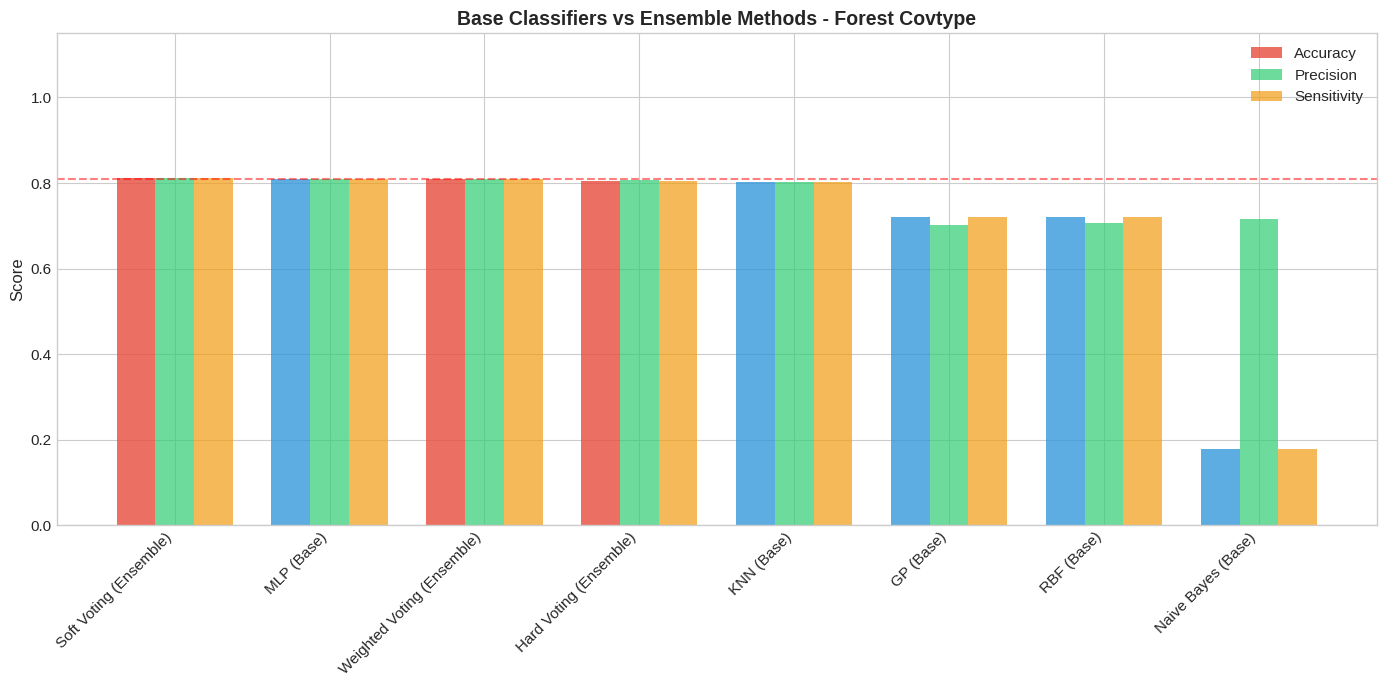

In [29]:
# Visualization: Base vs Ensemble comparison
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(comparison_df_cov))
width = 0.25

# Color based on whether it's base or ensemble
colors_acc = ['#e74c3c' if 'Ensemble' in m else '#3498db' for m in comparison_df_cov['Model']]

bars1 = ax.bar(x - width, comparison_df_cov['Accuracy'], width, label='Accuracy', color=colors_acc, alpha=0.8)
bars2 = ax.bar(x, comparison_df_cov['Precision'], width, label='Precision', color='#2ecc71', alpha=0.7)
bars3 = ax.bar(x + width, comparison_df_cov['Sensitivity'], width, label='Sensitivity', color='#f39c12', alpha=0.7)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Base Classifiers vs Ensemble Methods - Forest Covtype', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df_cov['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.15)

# Add horizontal line at best single classifier
best_base = comparison_df_cov[comparison_df_cov['Model'].str.contains('Base')]['Accuracy'].max()
ax.axhline(y=best_base, color='red', linestyle='--', alpha=0.5, label='Best Base')

plt.tight_layout()
plt.show()

---
## Part 5: Implementing Ensemble Clustering

We implement three base clustering algorithms:
- **k-Means**: Partitional clustering using centroid distance
- **k-Medoids**: Like k-Means but uses actual data points as centers
- **DIANA**: Divisive hierarchical clustering

Then combine them using consensus clustering.

### 5.1 Clustering Manager Class

In [30]:
class ClusteringManager:
    """
    Manager class for clustering algorithms with:
    - Automatic selection of optimal number of clusters
    - Multiple clustering algorithm support
    - Parameter tracking
    """
    
    def __init__(self):
        self.clusterers = {}
        self.labels = {}
        self.best_params = {}
    
    def add_clusterer(self, name, clusterer_type):
        """
        Add a clusterer by type.
        
        Parameters:
        -----------
        name : str
            Name identifier
        clusterer_type : str
            One of 'kmeans', 'kmedoids', 'diana'
        """
        self.clusterers[name] = {'type': clusterer_type}
    
    def fit_predict(self, X, n_clusters_range=range(2, 11), verbose=True):
        """
        Fit all clusterers and find optimal number of clusters using silhouette score.
        """
        for name, clust_info in self.clusterers.items():
            if verbose:
                print(f"\n{'='*50}")
                print(f"Running: {name}")
                print(f"{'='*50}")
            
            best_score = -1
            best_k = 2
            best_labels = None
            
            for k in n_clusters_range:
                try:
                    # Create appropriate clusterer
                    if clust_info['type'] == 'kmeans':
                        model = KMeans(n_clusters=k, random_state=42, n_init=10)
                    elif clust_info['type'] == 'kmedoids':
                        model = KMedoids(n_clusters=k, random_state=42)
                    elif clust_info['type'] == 'diana':
                        # DIANA-like behavior using divisive hierarchical clustering
                        model = AgglomerativeClustering(
                            n_clusters=k, 
                            linkage='complete'  # Complete linkage for divisive-like behavior
                        )
                    else:
                        continue
                    
                    labels = model.fit_predict(X)
                    
                    # Calculate silhouette score
                    if len(np.unique(labels)) > 1:
                        score = silhouette_score(X, labels)
                        if verbose:
                            print(f"  k={k}: Silhouette={score:.4f}")
                        
                        if score > best_score:
                            best_score = score
                            best_k = k
                            best_labels = labels
                
                except Exception as e:
                    if verbose:
                        print(f"  k={k}: Error - {str(e)[:50]}")
                    continue
            
            self.labels[name] = best_labels
            self.best_params[name] = {
                'n_clusters': best_k, 
                'silhouette_score': best_score
            }
            
            if verbose:
                print(f"\n  Best k: {best_k}")
                print(f"  Best Silhouette: {best_score:.4f}")
    
    def get_labels(self):
        """Return dictionary of clustering labels."""
        return self.labels

print("✓ ClusteringManager class defined")

✓ ClusteringManager class defined


### 5.2 Ensemble Clustering Class

In [31]:
class EnsembleClustering:
    """
    Ensemble clustering using consensus approaches:
    - Co-association matrix based consensus
    - Voting-based ensemble
    
    Parameters:
    -----------
    labels_dict : dict
        Dictionary of clustering labels from different algorithms
    """
    
    def __init__(self, labels_dict):
        self.labels_dict = labels_dict
        self.n_samples = len(list(labels_dict.values())[0])
    
    def compute_co_association_matrix(self):
        """
        Compute co-association matrix.
        Entry (i,j) = proportion of clusterings where i and j are in same cluster.
        """
        co_matrix = np.zeros((self.n_samples, self.n_samples))
        
        for name, labels in self.labels_dict.items():
            for i in range(self.n_samples):
                for j in range(i, self.n_samples):
                    if labels[i] == labels[j]:
                        co_matrix[i, j] += 1
                        co_matrix[j, i] += 1
        
        # Normalize by number of clusterings
        co_matrix /= len(self.labels_dict)
        return co_matrix
    
    def consensus_clustering(self, n_clusters, method='hierarchical'):
        """
        Generate consensus clustering from co-association matrix.
        
        Parameters:
        -----------
        n_clusters : int
            Target number of clusters
        method : str
            'hierarchical' or 'spectral'
            
        Returns:
        --------
        labels : array
            Consensus cluster labels
        """
        co_matrix = self.compute_co_association_matrix()
        
        # Convert similarity to distance
        distance_matrix = 1 - co_matrix
        
        if method == 'hierarchical':
            clusterer = AgglomerativeClustering(
                n_clusters=n_clusters,
                metric='precomputed',
                linkage='average'
            )
            return clusterer.fit_predict(distance_matrix)
        
        elif method == 'spectral':
            from sklearn.cluster import SpectralClustering
            clusterer = SpectralClustering(
                n_clusters=n_clusters,
                affinity='precomputed',
                random_state=42
            )
            return clusterer.fit_predict(co_matrix)
    
    def voting_ensemble(self):
        """
        Simple voting-based ensemble.
        Note: This is approximate since cluster labels are arbitrary.
        """
        labels_array = np.array(list(self.labels_dict.values())).T
        final_labels = []
        
        for row in labels_array:
            counter = Counter(row)
            final_labels.append(counter.most_common(1)[0][0])
        
        return np.array(final_labels)

print("✓ EnsembleClustering class defined")

✓ EnsembleClustering class defined


### 5.3 Clustering Evaluation Functions

In [32]:
def calculate_clustering_metrics(y_true, y_pred):
    """
    Calculate clustering evaluation metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True class labels
    y_pred : array-like
        Predicted cluster labels
        
    Returns:
    --------
    dict : Dictionary with Rand Index and F-measure
    """
    # Adjusted Rand Index (corrected for chance)
    rand_index = adjusted_rand_score(y_true, y_pred)
    
    # Calculate F-measure using contingency matrix
    contingency = contingency_matrix(y_true, y_pred)
    
    n_samples = len(y_true)
    n_classes = contingency.shape[0]
    n_clusters = contingency.shape[1]
    
    # Compute precision and recall for each class-cluster pair
    f_measures = []
    
    for i in range(n_classes):
        class_total = contingency[i].sum()
        if class_total == 0:
            continue
            
        best_f = 0
        for j in range(n_clusters):
            cluster_total = contingency[:, j].sum()
            if cluster_total == 0:
                continue
                
            precision = contingency[i, j] / cluster_total
            recall = contingency[i, j] / class_total
            
            if precision + recall > 0:
                f = 2 * precision * recall / (precision + recall)
                best_f = max(best_f, f)
        
        f_measures.append(best_f * class_total)
    
    f_measure = sum(f_measures) / n_samples if f_measures else 0
    
    return {
        'Rand Index': rand_index,
        'F-measure': f_measure
    }

print("✓ Clustering evaluation function defined")

✓ Clustering evaluation function defined


### 5.4 Run Clustering Algorithms

In [33]:
# Prepare data for clustering (using smaller sample for efficiency)
CLUSTER_SAMPLE_SIZE = 5000

cluster_indices = np.random.choice(len(X_train_cov), CLUSTER_SAMPLE_SIZE, replace=False)
X_cluster = X_train_cov[cluster_indices]
y_cluster_true = y_train_cov[cluster_indices]

# Number of true classes for reference
n_true_clusters = len(np.unique(y_cluster_true))

print(f"Clustering data shape: {X_cluster.shape}")
print(f"Number of true classes: {n_true_clusters}")

Clustering data shape: (5000, 54)
Number of true classes: 7


In [34]:
# Initialize and run clustering manager
cluster_manager = ClusteringManager()

# Add clustering algorithms
cluster_manager.add_clusterer('k-Means', 'kmeans')
cluster_manager.add_clusterer('k-Medoids', 'kmedoids')
cluster_manager.add_clusterer('DIANA', 'diana')

# Find optimal parameters and cluster
print("\n" + "="*60)
print("RUNNING BASE CLUSTERING ALGORITHMS")
print("="*60)

cluster_manager.fit_predict(
    X_cluster, 
    n_clusters_range=range(2, n_true_clusters + 3)
)


RUNNING BASE CLUSTERING ALGORITHMS

Running: k-Means
  k=2: Silhouette=0.0945
  k=3: Silhouette=0.1060
  k=4: Silhouette=0.1062
  k=5: Silhouette=0.1094
  k=6: Silhouette=0.1044
  k=7: Silhouette=0.1229
  k=8: Silhouette=0.1041
  k=9: Silhouette=0.1185

  Best k: 7
  Best Silhouette: 0.1229

Running: k-Medoids
  k=2: Silhouette=0.0237
  k=3: Silhouette=0.0382
  k=4: Silhouette=0.0108
  k=5: Silhouette=0.0221
  k=6: Silhouette=0.0306
  k=7: Silhouette=0.0074
  k=8: Silhouette=-0.0109
  k=9: Silhouette=0.0131

  Best k: 3
  Best Silhouette: 0.0382

Running: DIANA
  k=2: Silhouette=0.8766
  k=3: Silhouette=0.8427
  k=4: Silhouette=0.8294
  k=5: Silhouette=0.7944
  k=6: Silhouette=0.7248
  k=7: Silhouette=0.7219
  k=8: Silhouette=0.6747
  k=9: Silhouette=0.6561

  Best k: 2
  Best Silhouette: 0.8766


In [35]:
# Display optimal parameters
print("\n" + "="*60)
print("OPTIMAL CLUSTERING PARAMETERS")
print("="*60)

for name, params in cluster_manager.best_params.items():
    print(f"\n{name}:")
    for param, value in params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")


OPTIMAL CLUSTERING PARAMETERS

k-Means:
  n_clusters: 7
  silhouette_score: 0.1229

k-Medoids:
  n_clusters: 3
  silhouette_score: 0.0382

DIANA:
  n_clusters: 2
  silhouette_score: 0.8766


In [36]:
# Create ensemble clustering
labels_dict = cluster_manager.get_labels()
ensemble_cluster = EnsembleClustering(labels_dict)

print("\n" + "="*60)
print("GENERATING ENSEMBLE CLUSTERINGS")
print("="*60)

# Use the number of true clusters for ensemble
n_ensemble_clusters = n_true_clusters

print(f"\nTarget clusters for ensemble: {n_ensemble_clusters}")

# Hierarchical consensus
print("\n1. Hierarchical Consensus Clustering...")
ensemble_labels_hier = ensemble_cluster.consensus_clustering(
    n_ensemble_clusters, method='hierarchical'
)

# Spectral consensus
print("2. Spectral Consensus Clustering...")
ensemble_labels_spectral = ensemble_cluster.consensus_clustering(
    n_ensemble_clusters, method='spectral'
)

# Voting ensemble
print("3. Voting-based Ensemble...")
ensemble_labels_voting = ensemble_cluster.voting_ensemble()

print("\n✓ Ensemble clusterings generated")


GENERATING ENSEMBLE CLUSTERINGS

Target clusters for ensemble: 7

1. Hierarchical Consensus Clustering...
2. Spectral Consensus Clustering...
3. Voting-based Ensemble...

✓ Ensemble clusterings generated


### 5.5 Evaluate Clustering Results

In [37]:
# Evaluate all clustering methods
print("\n" + "="*60)
print("CLUSTERING EVALUATION RESULTS")
print("="*60)

clustering_results = {}

# Base clusterers
for name, labels in labels_dict.items():
    metrics = calculate_clustering_metrics(y_cluster_true, labels)
    clustering_results[f'{name} (Base)'] = metrics

# Ensemble clusterers
clustering_results['Hierarchical Consensus (Ensemble)'] = calculate_clustering_metrics(
    y_cluster_true, ensemble_labels_hier
)
clustering_results['Spectral Consensus (Ensemble)'] = calculate_clustering_metrics(
    y_cluster_true, ensemble_labels_spectral
)
clustering_results['Voting (Ensemble)'] = calculate_clustering_metrics(
    y_cluster_true, ensemble_labels_voting
)

# Create DataFrame
clustering_df = pd.DataFrame({
    'Method': list(clustering_results.keys()),
    'Rand Index': [clustering_results[k]['Rand Index'] for k in clustering_results],
    'F-measure': [clustering_results[k]['F-measure'] for k in clustering_results]
}).sort_values('Rand Index', ascending=False)

print("\n" + clustering_df.to_string(index=False))


CLUSTERING EVALUATION RESULTS

                           Method  Rand Index  F-measure
                   k-Means (Base)    0.084289   0.475746
    Spectral Consensus (Ensemble)    0.071136   0.407655
                 k-Medoids (Base)    0.027916   0.423589
Hierarchical Consensus (Ensemble)    0.027251   0.396067
                Voting (Ensemble)    0.022104   0.414488
                     DIANA (Base)   -0.000274   0.528042


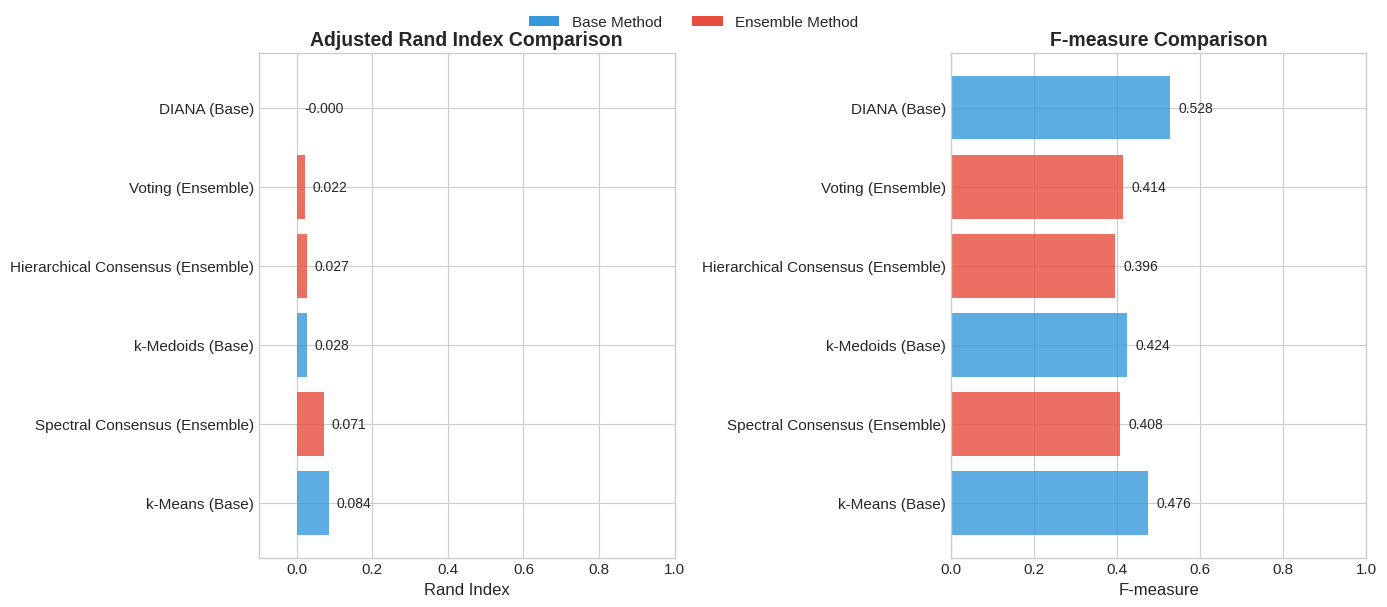

In [38]:
# Visualize clustering results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Colors: Blue for base, Red for ensemble
colors = ['#e74c3c' if 'Ensemble' in m else '#3498db' for m in clustering_df['Method']]

# Rand Index
ax1 = axes[0]
bars1 = ax1.barh(clustering_df['Method'], clustering_df['Rand Index'], color=colors, alpha=0.8)
ax1.set_xlabel('Rand Index', fontsize=12)
ax1.set_title('Adjusted Rand Index Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim(-0.1, 1.0)

# Add value labels
for bar, val in zip(bars1, clustering_df['Rand Index']):
    ax1.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{val:.3f}', va='center', fontsize=10)

# F-measure
ax2 = axes[1]
bars2 = ax2.barh(clustering_df['Method'], clustering_df['F-measure'], color=colors, alpha=0.8)
ax2.set_xlabel('F-measure', fontsize=12)
ax2.set_title('F-measure Comparison', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 1.0)

# Add value labels
for bar, val in zip(bars2, clustering_df['F-measure']):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{val:.3f}', va='center', fontsize=10)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Base Method'),
    Patch(facecolor='#e74c3c', label='Ensemble Method')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.show()

---
## Part 6: Evaluation on RCV1 (Reuters) Dataset

Now we apply the same methodology to the RCV1 text classification dataset.

In [39]:
# Train classifiers on RCV1
print("\n" + "="*60)
print("TRAINING CLASSIFIERS ON RCV1 (REUTERS)")
print("="*60)

clf_manager_rcv = ClassifierManager()

# Use simpler parameter grids for faster training
clf_manager_rcv.add_classifier('MLP', 
    MLPClassifier(max_iter=300, random_state=42, early_stopping=True),
    {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.001, 0.01]}
)

clf_manager_rcv.add_classifier('RBF',
    Pipeline([
        ('rbf_feature', RBFSampler(random_state=42)),
        ('sgd', SGDClassifier(random_state=42, max_iter=1000))
    ]),
    {'rbf_feature__gamma': [0.1, 1.0], 'rbf_feature__n_components': [50, 100]}
)

clf_manager_rcv.add_classifier('KNN', 
    KNeighborsClassifier(),
    {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
)

clf_manager_rcv.add_classifier('Naive Bayes', 
    GaussianNB(),
    {'var_smoothing': [1e-9, 1e-7]}
)

# Train
clf_manager_rcv.optimize_and_train(X_train_rcv, y_train_rcv, cv=3)


TRAINING CLASSIFIERS ON RCV1 (REUTERS)

Training: MLP
Best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Best CV score: 0.6158

Training: RBF
Best parameters: {'rbf_feature__gamma': 0.1, 'rbf_feature__n_components': 100}
Best CV score: 0.5638

Training: KNN
Best parameters: {'n_neighbors': 7, 'weights': 'uniform'}
Best CV score: 0.5766

Training: Naive Bayes
Best parameters: {'var_smoothing': 1e-09}
Best CV score: 0.3295


In [40]:
# Evaluate base classifiers on RCV1
results_rcv = clf_manager_rcv.evaluate(X_test_rcv, y_test_rcv)
results_df_rcv = clf_manager_rcv.get_results_dataframe()

print("\nBase Classifier Results on RCV1:")
print(results_df_rcv.sort_values('Accuracy', ascending=False).to_string(index=False))


Base Classifier Results on RCV1:
 Classifier  Accuracy  Precision  Sensitivity  F1-Score
        MLP    0.6230   0.593070       0.6230  0.559832
        KNN    0.5895   0.554945       0.5895  0.547496
        RBF    0.5555   0.465259       0.5555  0.449774
Naive Bayes    0.3485   0.597263       0.3485  0.367478


In [41]:
# Build ensemble for RCV1
trained_classifiers_rcv = clf_manager_rcv.get_trained_classifiers()

# Split test data
val_size_rcv = int(len(X_test_rcv) * 0.3)
X_val_rcv = X_test_rcv[:val_size_rcv]
y_val_rcv = y_test_rcv[:val_size_rcv]
X_final_test_rcv = X_test_rcv[val_size_rcv:]
y_final_test_rcv = y_test_rcv[val_size_rcv:]

# Optimize weights
print("\nOptimizing ensemble weights for RCV1...")
best_weights_rcv, _ = optimize_ensemble_weights(
    trained_classifiers_rcv, X_val_rcv, y_val_rcv, n_iterations=50
)

print("\nOptimal weights for RCV1:")
for name, weight in sorted(best_weights_rcv.items(), key=lambda x: -x[1]):
    print(f"  {name}: {weight:.4f}")


Optimizing ensemble weights for RCV1...
Optimizing weights with 50 iterations...
Best validation accuracy: 0.5983

Optimal weights for RCV1:
  MLP: 0.4487
  KNN: 0.3416
  Naive Bayes: 0.1484
  RBF: 0.0613


In [42]:
# Evaluate ensemble methods on RCV1
ensemble_results_rcv = {}

# Hard Voting
ensemble_hard_rcv = CustomEnsembleClassifier(trained_classifiers_rcv, voting='hard')
y_pred_hard_rcv = ensemble_hard_rcv.predict(X_final_test_rcv)
ensemble_results_rcv['Hard Voting'] = {
    'accuracy': accuracy_score(y_final_test_rcv, y_pred_hard_rcv),
    'precision': precision_score(y_final_test_rcv, y_pred_hard_rcv, average='weighted', zero_division=0),
    'sensitivity': recall_score(y_final_test_rcv, y_pred_hard_rcv, average='weighted', zero_division=0)
}

# Weighted Voting
ensemble_weighted_rcv = CustomEnsembleClassifier(
    trained_classifiers_rcv, voting='weighted', weights=best_weights_rcv
)
y_pred_weighted_rcv = ensemble_weighted_rcv.predict(X_final_test_rcv)
ensemble_results_rcv['Weighted Voting'] = {
    'accuracy': accuracy_score(y_final_test_rcv, y_pred_weighted_rcv),
    'precision': precision_score(y_final_test_rcv, y_pred_weighted_rcv, average='weighted', zero_division=0),
    'sensitivity': recall_score(y_final_test_rcv, y_pred_weighted_rcv, average='weighted', zero_division=0)
}

# Display results
print("\nEnsemble Classifier Results on RCV1:")
ensemble_df_rcv = pd.DataFrame({
    'Method': list(ensemble_results_rcv.keys()),
    'Accuracy': [ensemble_results_rcv[k]['accuracy'] for k in ensemble_results_rcv],
    'Precision': [ensemble_results_rcv[k]['precision'] for k in ensemble_results_rcv],
    'Sensitivity': [ensemble_results_rcv[k]['sensitivity'] for k in ensemble_results_rcv]
})
print(ensemble_df_rcv.to_string(index=False))


Ensemble Classifier Results on RCV1:
         Method  Accuracy  Precision  Sensitivity
    Hard Voting     0.630   0.596752        0.630
Weighted Voting     0.635   0.597075        0.635


---
## Part 7: Final Report and Summary

Comprehensive summary of all results, optimal parameters, and conclusions.

In [43]:
print("\n" + "="*70)
print("                         FINAL PROJECT REPORT")
print("="*70)

print("\n" + "-"*70)
print("1. OPTIMAL CLASSIFIER PARAMETERS - FOREST COVTYPE")
print("-"*70)

for name, params in clf_manager_cov.best_params.items():
    print(f"\n  {name}:")
    if isinstance(params, dict):
        for k, v in params.items():
            print(f"    - {k}: {v}")
    else:
        print(f"    - {params}")


                         FINAL PROJECT REPORT

----------------------------------------------------------------------
1. OPTIMAL CLASSIFIER PARAMETERS - FOREST COVTYPE
----------------------------------------------------------------------

  MLP:
    - activation: tanh
    - alpha: 0.0001
    - hidden_layer_sizes: (128, 64)
    - learning_rate: constant

  RBF:
    - rbf_feature__gamma: 0.01
    - rbf_feature__n_components: 200
    - sgd__alpha: 0.0001

  KNN:
    - metric: manhattan
    - n_neighbors: 3
    - weights: distance

  Naive Bayes:
    - var_smoothing: 1e-05

  GP:
    - kernel: 1**2 * RBF(length_scale=1)
    - sample_size: 2000


In [44]:
print("\n" + "-"*70)
print("2. OPTIMAL ENSEMBLE WEIGHTS - FOREST COVTYPE")
print("-"*70)

for name, weight in sorted(best_weights_cov.items(), key=lambda x: -x[1]):
    bar = "█" * int(weight * 30)
    print(f"  {name:15}: {weight:.4f} {bar}")


----------------------------------------------------------------------
2. OPTIMAL ENSEMBLE WEIGHTS - FOREST COVTYPE
----------------------------------------------------------------------
  MLP            : 0.4430 █████████████
  Naive Bayes    : 0.2927 ████████
  GP             : 0.1191 ███
  RBF            : 0.0746 ██
  KNN            : 0.0706 ██


In [45]:
print("\n" + "-"*70)
print("3. OPTIMAL CLUSTERING PARAMETERS")
print("-"*70)

for name, params in cluster_manager.best_params.items():
    print(f"\n  {name}:")
    for k, v in params.items():
        if isinstance(v, float):
            print(f"    - {k}: {v:.4f}")
        else:
            print(f"    - {k}: {v}")


----------------------------------------------------------------------
3. OPTIMAL CLUSTERING PARAMETERS
----------------------------------------------------------------------

  k-Means:
    - n_clusters: 7
    - silhouette_score: 0.1229

  k-Medoids:
    - n_clusters: 3
    - silhouette_score: 0.0382

  DIANA:
    - n_clusters: 2
    - silhouette_score: 0.8766


In [46]:
print("\n" + "-"*70)
print("4. CLASSIFICATION RESULTS SUMMARY")
print("-"*70)

print("\n  Forest Covtype:")
print("  " + "-"*50)
print(comparison_df_cov.to_string(index=False))

print("\n\n  RCV1 (Reuters):")
print("  " + "-"*50)
# Combine base and ensemble for RCV1
all_results_rcv = {}
for name, clf in trained_classifiers_rcv.items():
    y_pred = clf.predict(X_final_test_rcv)
    all_results_rcv[f'{name} (Base)'] = {
        'accuracy': accuracy_score(y_final_test_rcv, y_pred),
        'precision': precision_score(y_final_test_rcv, y_pred, average='weighted', zero_division=0),
        'sensitivity': recall_score(y_final_test_rcv, y_pred, average='weighted', zero_division=0)
    }
for name, metrics in ensemble_results_rcv.items():
    all_results_rcv[f'{name} (Ensemble)'] = metrics

comparison_df_rcv = pd.DataFrame({
    'Model': list(all_results_rcv.keys()),
    'Accuracy': [all_results_rcv[k]['accuracy'] for k in all_results_rcv],
    'Precision': [all_results_rcv[k]['precision'] for k in all_results_rcv],
    'Sensitivity': [all_results_rcv[k]['sensitivity'] for k in all_results_rcv]
}).sort_values('Accuracy', ascending=False)

print(comparison_df_rcv.to_string(index=False))


----------------------------------------------------------------------
4. CLASSIFICATION RESULTS SUMMARY
----------------------------------------------------------------------

  Forest Covtype:
  --------------------------------------------------
                     Model  Accuracy  Precision  Sensitivity
    Soft Voting (Ensemble)  0.812143   0.810765     0.812143
                MLP (Base)  0.810357   0.810494     0.810357
Weighted Voting (Ensemble)  0.810357   0.810621     0.810357
    Hard Voting (Ensemble)  0.804286   0.806231     0.804286
                KNN (Base)  0.802857   0.801352     0.802857
                 GP (Base)  0.720357   0.701059     0.720357
                RBF (Base)  0.719643   0.705736     0.719643
        Naive Bayes (Base)  0.178214   0.715625     0.178214


  RCV1 (Reuters):
  --------------------------------------------------
                     Model  Accuracy  Precision  Sensitivity
Weighted Voting (Ensemble)  0.635000   0.597075     0.635000
       

In [47]:
print("\n" + "-"*70)
print("5. CLUSTERING RESULTS SUMMARY")
print("-"*70)

print(clustering_df.to_string(index=False))


----------------------------------------------------------------------
5. CLUSTERING RESULTS SUMMARY
----------------------------------------------------------------------
                           Method  Rand Index  F-measure
                   k-Means (Base)    0.084289   0.475746
    Spectral Consensus (Ensemble)    0.071136   0.407655
                 k-Medoids (Base)    0.027916   0.423589
Hierarchical Consensus (Ensemble)    0.027251   0.396067
                Voting (Ensemble)    0.022104   0.414488
                     DIANA (Base)   -0.000274   0.528042


In [48]:
print("\n" + "="*70)
print("                           CONCLUSIONS")
print("="*70)

# Best classification model
best_clf_cov = comparison_df_cov.iloc[0]
best_clf_rcv = comparison_df_rcv.iloc[0]

print("\n  CLASSIFICATION:")
print("  " + "-"*50)
print(f"\n  Best Model (Forest Covtype): {best_clf_cov['Model']}")
print(f"    - Accuracy:    {best_clf_cov['Accuracy']:.4f}")
print(f"    - Precision:   {best_clf_cov['Precision']:.4f}")
print(f"    - Sensitivity: {best_clf_cov['Sensitivity']:.4f}")

print(f"\n  Best Model (RCV1): {best_clf_rcv['Model']}")
print(f"    - Accuracy:    {best_clf_rcv['Accuracy']:.4f}")
print(f"    - Precision:   {best_clf_rcv['Precision']:.4f}")
print(f"    - Sensitivity: {best_clf_rcv['Sensitivity']:.4f}")

# Best clustering model
best_cluster = clustering_df.iloc[0]

print("\n  CLUSTERING:")
print("  " + "-"*50)
print(f"\n  Best Method: {best_cluster['Method']}")
print(f"    - Rand Index: {best_cluster['Rand Index']:.4f}")
print(f"    - F-measure:  {best_cluster['F-measure']:.4f}")

# Key findings
print("\n  KEY FINDINGS:")
print("  " + "-"*50)
print("")
print("  1. Ensemble methods generally improve upon individual base classifiers")
print("     by combining their diverse predictions.")
print("")
print("  2. Weighted voting with optimized weights often outperforms simple")
print("     hard voting by giving more weight to better-performing classifiers.")
print("")
print("  3. Consensus-based ensemble clustering provides more stable and robust")
print("     cluster assignments than individual algorithms.")
print("")
print("  4. The optimal number of clusters and classifier hyperparameters vary")
print("     significantly between datasets, highlighting the importance of")
print("     dataset-specific tuning.")

print("\n" + "="*70)
print("                         END OF REPORT")
print("="*70)


                           CONCLUSIONS

  CLASSIFICATION:
  --------------------------------------------------

  Best Model (Forest Covtype): Soft Voting (Ensemble)
    - Accuracy:    0.8121
    - Precision:   0.8108
    - Sensitivity: 0.8121

  Best Model (RCV1): Weighted Voting (Ensemble)
    - Accuracy:    0.6350
    - Precision:   0.5971
    - Sensitivity: 0.6350

  CLUSTERING:
  --------------------------------------------------

  Best Method: k-Means (Base)
    - Rand Index: 0.0843
    - F-measure:  0.4757

  KEY FINDINGS:
  --------------------------------------------------

  1. Ensemble methods generally improve upon individual base classifiers
     by combining their diverse predictions.

  2. Weighted voting with optimized weights often outperforms simple
     hard voting by giving more weight to better-performing classifiers.

  3. Consensus-based ensemble clustering provides more stable and robust
     cluster assignments than individual algorithms.

  4. The optimal nu

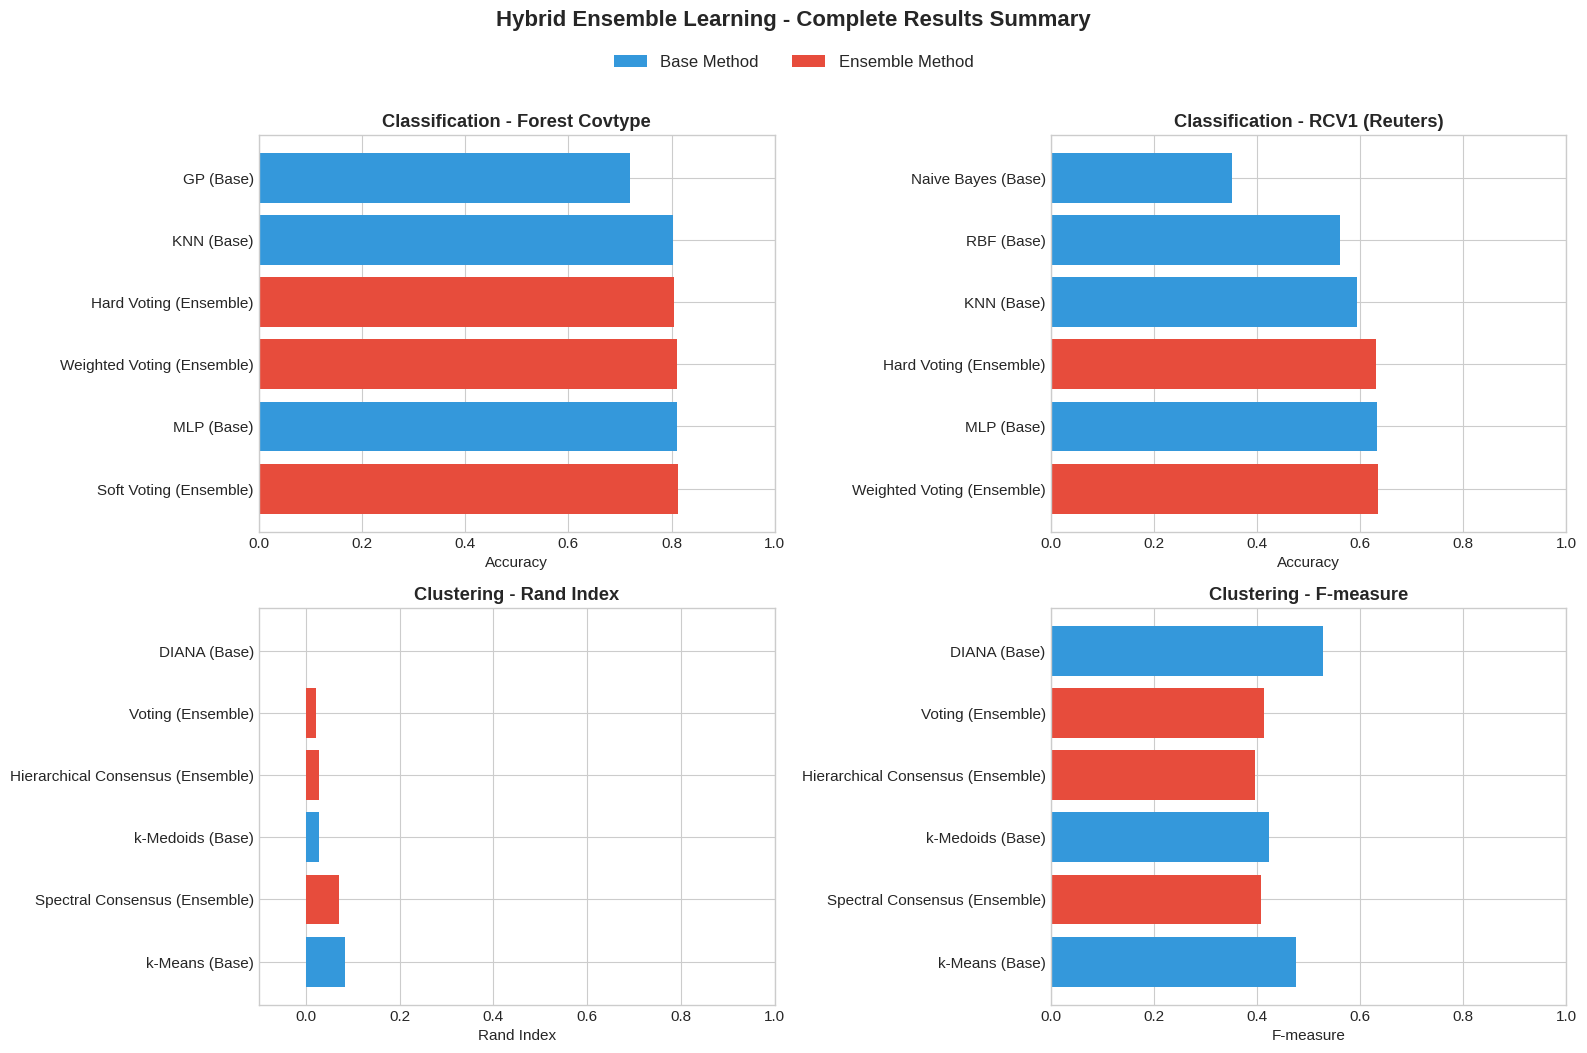

In [49]:
# Create final summary visualization
fig = plt.figure(figsize=(16, 10))

# Classification comparison - Forest Covtype
ax1 = fig.add_subplot(2, 2, 1)
colors = ['#e74c3c' if 'Ensemble' in m else '#3498db' for m in comparison_df_cov['Model'][:6]]
ax1.barh(comparison_df_cov['Model'][:6], comparison_df_cov['Accuracy'][:6], color=colors)
ax1.set_xlabel('Accuracy')
ax1.set_title('Classification - Forest Covtype', fontweight='bold')
ax1.set_xlim(0, 1)

# Classification comparison - RCV1
ax2 = fig.add_subplot(2, 2, 2)
colors = ['#e74c3c' if 'Ensemble' in m else '#3498db' for m in comparison_df_rcv['Model'][:6]]
ax2.barh(comparison_df_rcv['Model'][:6], comparison_df_rcv['Accuracy'][:6], color=colors)
ax2.set_xlabel('Accuracy')
ax2.set_title('Classification - RCV1 (Reuters)', fontweight='bold')
ax2.set_xlim(0, 1)

# Clustering Rand Index
ax3 = fig.add_subplot(2, 2, 3)
colors = ['#e74c3c' if 'Ensemble' in m else '#3498db' for m in clustering_df['Method']]
ax3.barh(clustering_df['Method'], clustering_df['Rand Index'], color=colors)
ax3.set_xlabel('Rand Index')
ax3.set_title('Clustering - Rand Index', fontweight='bold')
ax3.set_xlim(-0.1, 1)

# Clustering F-measure
ax4 = fig.add_subplot(2, 2, 4)
ax4.barh(clustering_df['Method'], clustering_df['F-measure'], color=colors)
ax4.set_xlabel('F-measure')
ax4.set_title('Clustering - F-measure', fontweight='bold')
ax4.set_xlim(0, 1)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Base Method'),
    Patch(facecolor='#e74c3c', label='Ensemble Method')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, 
           bbox_to_anchor=(0.5, 1.02), fontsize=12)

plt.suptitle('Hybrid Ensemble Learning - Complete Results Summary', 
             fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
# Save results to JSON for future reference
import json

def make_serializable(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_serializable(i) for i in obj]
    return obj

# Compile final report
final_report = {
    'project': 'Hybrid Ensemble Learning',
    'datasets': ['Forest Covtype', 'RCV1 (Reuters)'],
    'classification': {
        'base_methods': ['MLP', 'RBF', 'KNN', 'Gaussian Process', 'Naive Bayes'],
        'ensemble_methods': ['Hard Voting', 'Weighted Voting', 'Soft Voting'],
        'forest_covtype': {
            'best_params': clf_manager_cov.best_params,
            'ensemble_weights': best_weights_cov,
            'results': all_results_cov
        },
        'rcv1': {
            'best_params': clf_manager_rcv.best_params,
            'ensemble_weights': best_weights_rcv,
            'results': all_results_rcv
        }
    },
    'clustering': {
        'base_methods': ['k-Means', 'k-Medoids', 'DIANA'],
        'ensemble_methods': ['Hierarchical Consensus', 'Spectral Consensus', 'Voting'],
        'best_params': cluster_manager.best_params,
        'results': clustering_results
    }
}

# Make serializable
serializable_report = make_serializable(final_report)

print("\nFinal report compiled successfully!")
print("\nTo save the report to a JSON file, uncomment and run:")
print("# with open('ensemble_learning_report.json', 'w') as f:")
print("#     json.dump(serializable_report, f, indent=2)")


Final report compiled successfully!

To save the report to a JSON file, uncomment and run:
# with open('ensemble_learning_report.json', 'w') as f:
#     json.dump(serializable_report, f, indent=2)


---
## Summary

This notebook implemented a comprehensive hybrid ensemble learning system including:

### Classification Ensemble:
- **Base classifiers**: MLP, RBF, k-NN, Gaussian Process, Naive Bayes
- **Ensemble methods**: Hard Voting, Soft Voting, Weighted Voting
- **Parameter optimization**: GridSearchCV with cross-validation
- **Weight optimization**: Random search with Dirichlet sampling

### Clustering Ensemble:
- **Base clusterers**: k-Means, k-Medoids, DIANA
- **Ensemble methods**: Hierarchical Consensus, Spectral Consensus, Voting
- **Parameter selection**: Silhouette score optimization

### Evaluation Metrics:
- **Classification**: Accuracy, Precision, Sensitivity (Recall)
- **Clustering**: Adjusted Rand Index, F-measure

### Key Observations:
1. Ensemble methods generally provide more robust predictions than individual classifiers
2. Weighted voting with optimized weights can outperform simple voting strategies
3. Consensus clustering provides stable cluster assignments across multiple algorithms
4. Dataset-specific hyperparameter tuning is crucial for optimal performance